In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

In [2]:
classification_data, classification_labels = make_classification(n_samples=100, n_features=2, n_informative=2,
                                                                 n_redundant=0, n_repeated=0, random_state=42)

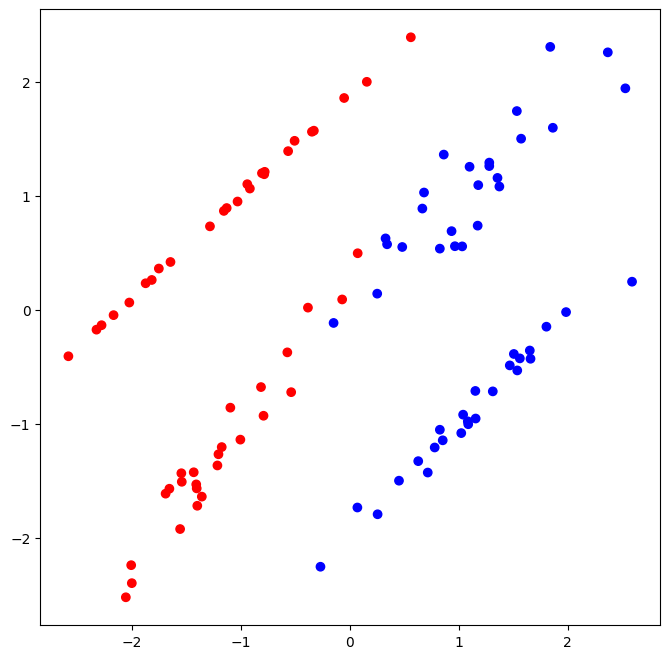

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])
plt.figure(figsize=(8, 8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], c=classification_labels, cmap=colors)

In [4]:
np.random.seed(42)


def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap


def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.round(np.sqrt(len_sample)))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    return subsample

In [5]:
print(get_bootstrap(classification_data, classification_labels, 1))
print(get_subsample(len(classification_data)))

[(array([[ 0.66530077,  0.88629356],
       [ 1.3727107 ,  1.07954187],
       [ 1.65214494, -0.35885569],
       [-1.69302842, -1.61453273],
       [-0.53963044, -0.72427983],
       [ 0.71479373, -1.42922002],
       [ 0.15513175,  1.99805321],
       [ 1.35536951,  1.15509316],
       [ 1.53313849,  1.74147706],
       [ 1.53313849,  1.74147706],
       [ 1.03967019, -0.92169432],
       [-1.75518644,  0.36016958],
       [-2.58590856, -0.40925706],
       [-1.5598485 , -1.92487377],
       [-0.15013844, -0.11708689],
       [ 1.17869556,  1.09180466],
       [ 1.31217492, -0.7173148 ],
       [ 1.03967019, -0.92169432],
       [ 0.25058844,  0.13979096],
       [-0.94275087,  1.10009583],
       [ 1.31217492, -0.7173148 ],
       [ 0.34129395,  0.57304248],
       [-1.13207427,  0.89075877],
       [ 0.71479373, -1.42922002],
       [-2.02632079,  0.06194498],
       [-1.43483867, -1.42695838],
       [ 0.4505902 , -1.50077611],
       [-0.15013844, -0.11708689],
       [-1.8203769

In [6]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch


class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        prediction = max(classes, key=classes.get)
        return prediction

In [7]:
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
            classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity


def gain(left_labels, right_labels, root_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels

In [8]:
def find_best_split(data, labels):
    root_gini = gini(labels)
    best_gain = 0
    best_index = best_t = None

    n_features = data.shape[1]
    feature_subsample_indices = get_subsample(n_features)

    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            current_gain = gain(true_labels, false_labels, root_gini)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [9]:
def build_tree(data, labels):
    _gain, t, index = find_best_split(data, labels)
    if _gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(index, t, true_branch, false_branch)

In [10]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest


def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [11]:
def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    predictions_per_obj = list(zip(*predictions))

    voted_predictions = []
    for obj in predictions_per_obj:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, classification_labels,
                                                                    test_size=0.3, random_state=1)


In [13]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [33]:
n_trees = [1, 3, 10, 50]
rf_models = []

for n in n_trees:
    rf = random_forest(train_data, train_labels, n)
    rf_models.append(rf)

In [34]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(my_forest):
    plt.figure(figsize = (16, 7))
    
    train_answs = tree_vote(my_forest, train_data)
    test_answs = tree_vote(my_forest, test_data)

    train_acc = accuracy_metric(train_labels, train_answs)
    test_acc = accuracy_metric(test_labels, test_answs)
    
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_acc:.2f}')
    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_acc:.2f}')

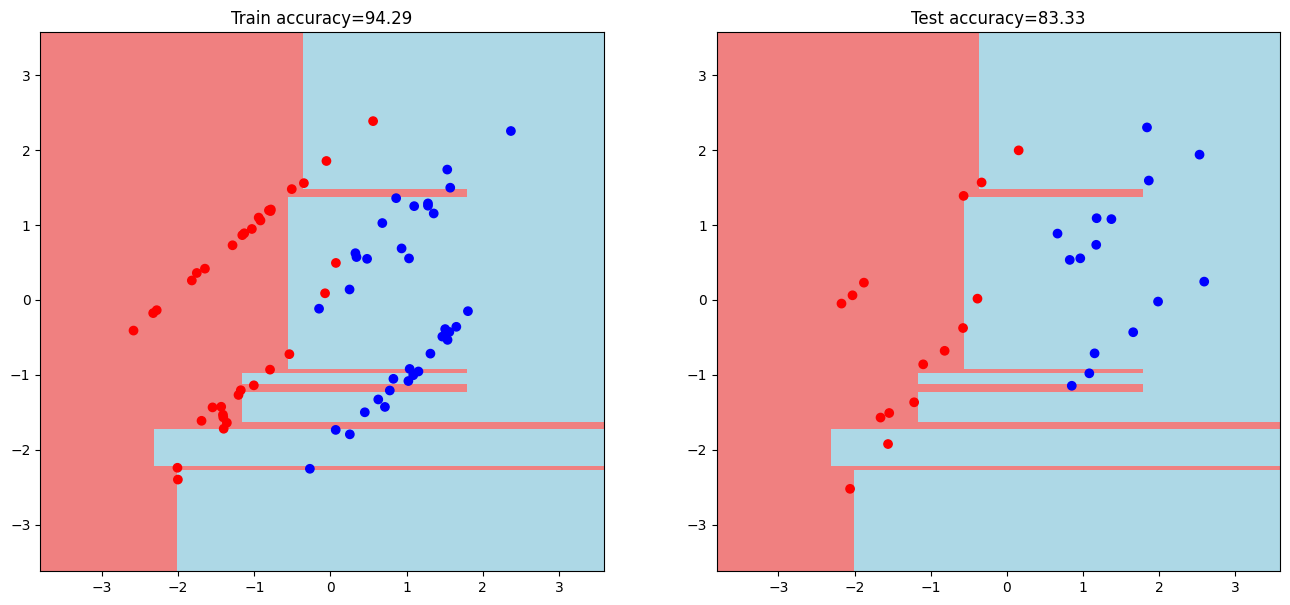

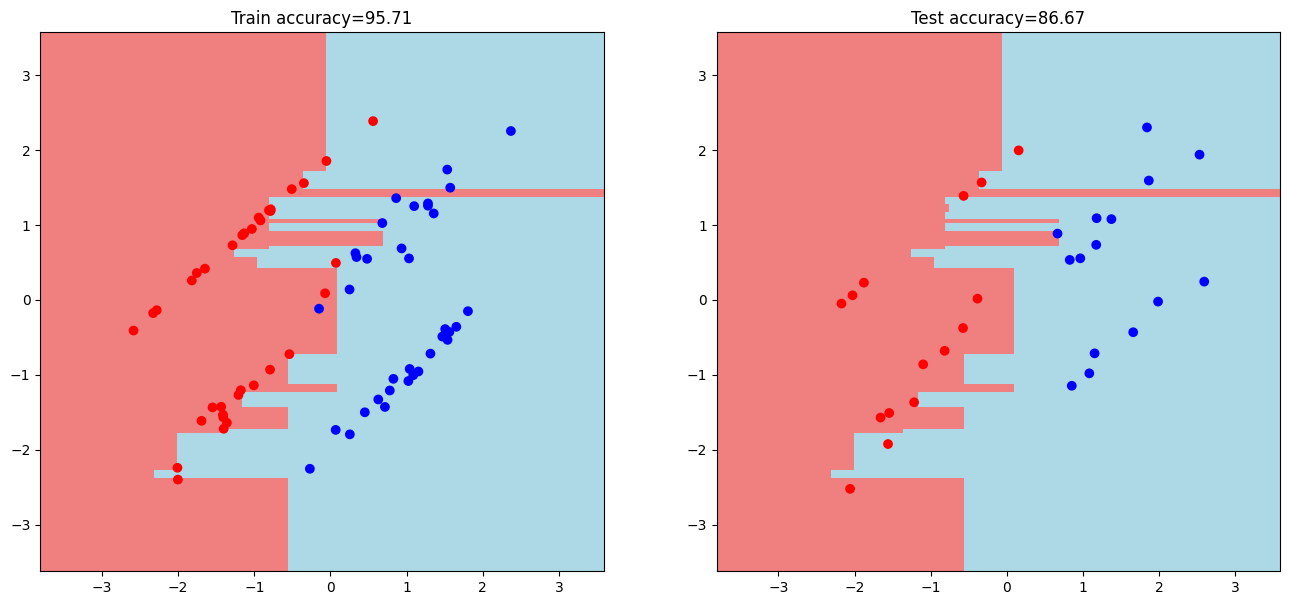

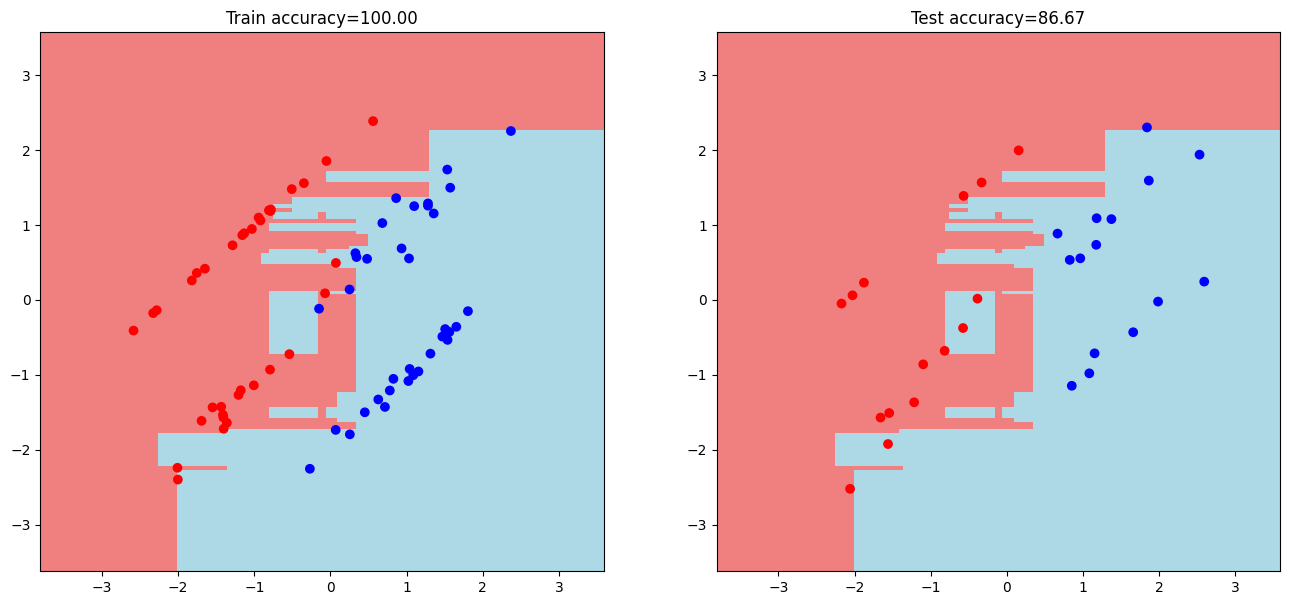

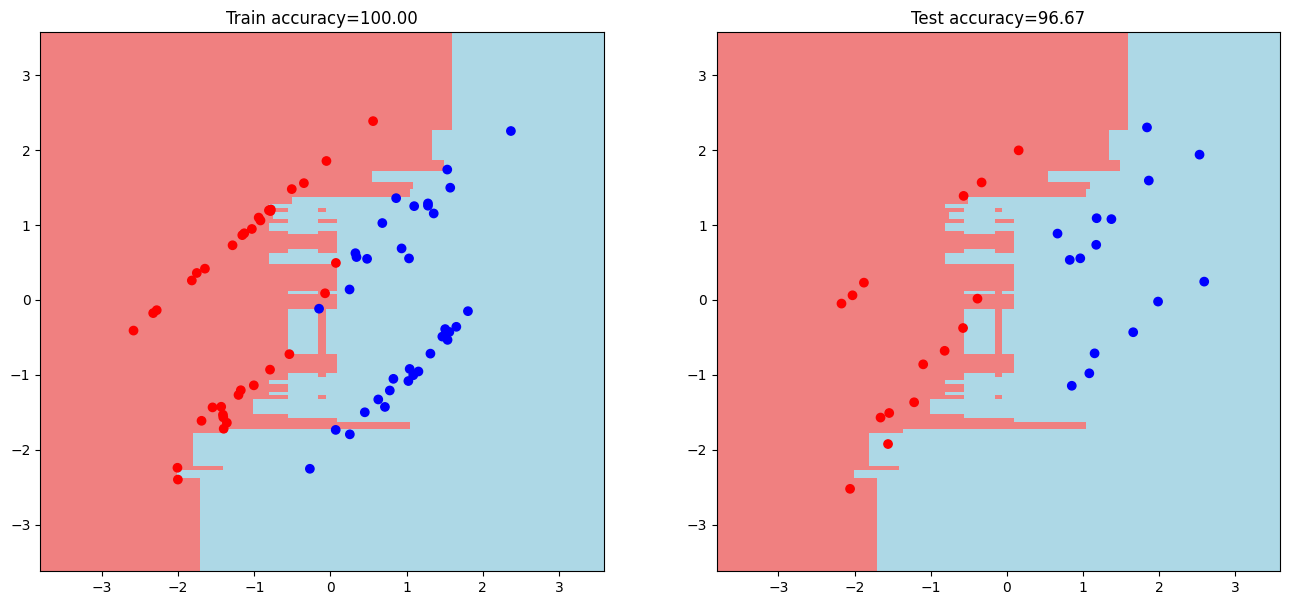

In [35]:
for rf_model in rf_models:
    visualize(rf_model)

In [45]:
import random

def get_bootstrap(data, labels, N, oob_score):
    
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    oob_examples = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        indicies = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            indicies.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
        
        if oob_score:
            oob_indicies = [idx for idx in range(n_samples) if idx not in set(indicies)]
            oob_data = data[oob_indicies]
            oob_labels = labels[oob_indicies]
            oob_examples.append((oob_data, oob_labels))
        
    return bootstrap, oob_examples

def calc_oob_acc(oob_examples, tree):
    oob_answers = predict(oob_examples[0], tree)
    oob_acc = accuracy_metric(oob_examples[1], oob_answers)
    return oob_acc

def random_forest(data, labels, n_trees, oob_score=False):
    forest = []
    bootstrap, oob_examples = get_bootstrap(data, labels, n_trees, oob_score=oob_score)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    if oob_score:
        oob_acc = 0
        for i in range(n_trees):
            oob_acc += calc_oob_acc(oob_examples[i], forest[i])
        
        oob_acc = oob_acc / n_trees
        return forest, oob_acc
    
    return forest

In [46]:
n_trees = 50
my_forest_50, oob_score = random_forest(train_data, train_labels, n_trees, oob_score=True)

In [47]:
oob_score

75.98206632907895